In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
from skimage import measure                        
from shapely.geometry import Polygon, MultiPolygon 
import cv2 
from PIL import Image # (pip install Pillow)
from utils.dataset_utils import get_cadisv2_dataset,ZEISS_CATEGORIES,ZEISS_TO_CADISV2,ZEISS_TO_CATARACT1K,get_cataract1k_dataset
import json
from utils.vis_utils import COLORS,NEW_COLORS
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

Coco generation code was adapted from: https://www.immersivelimit.com/create-coco-annotations-from-scratch

In [3]:
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd):
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, positive_orientation='low')#(sub_mask, 0.5, positive_orientation='low')
    #contours, _= cv2.findContours(sub_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
   
    
    segmentations = []
    polygons = []
    for contour in contours:
        #print(contour.shape)
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
       
        #poly = poly.simplify(1.0, preserve_topology=True)
        
        polygons.append(poly)
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
       
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
   
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': image_id,
        'category_id': category_id,
        'id': annotation_id,
        'bbox': bbox,
        'area': area
    }

    return annotation

In [4]:
def create_sub_masks(mask_image):
    width, height = mask_image.size

    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y))[:3]
            # If the pixel is not black...
            if pixel != (0, 0, 0):
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                   # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))
                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks


In [40]:
cadis_train_dataset, cadis_val_dataset, cadis_test_dataset= get_cadisv2_dataset("../data/CaDISv2", domain_incremental=True)
#cadis_train_dataset.class_mappings

In [6]:
is_crowd=0
annotation_id=1
annotations=[]
image_id=1
images=[]
dataset=cadis_train_dataset
for i in range(len(dataset)):
    
    img,mask,path=dataset[i]
    
    mask_pil=Image.fromarray(mask.numpy().astype('uint8')).convert('RGB')
    images.append({
            "path":path,
            "file_name": path.split("/")[-1],
            "height": mask_pil.size[0],
            "width": mask_pil.size[1],
            "id": image_id
        })
    sub_masks = create_sub_masks(mask_pil)
    for color, sub_mask in sub_masks.items():
        category_id = int(color[1:].split(",")[0])
        if category_id==255:
            continue
        annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
        if len(annotation)==0:
            print(image_id,path,"empty annotation",category_id)
        annotations.append(annotation)
        annotation_id += 1
    image_id+=1

In [41]:
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    if k<12:
        categories.append({"id":k,"name":v})
print(categories)

[{'id': 1, 'name': 'Knife'}, {'id': 2, 'name': 'Bonn forceps'}, {'id': 3, 'name': 'Cannula'}, {'id': 4, 'name': 'Capsulorhexis Cystotome'}, {'id': 5, 'name': 'Capsulorhexis forceps'}, {'id': 6, 'name': 'Phacoemulsification handpiece'}, {'id': 7, 'name': 'Micromanipulator'}, {'id': 8, 'name': 'I/A handpiece'}, {'id': 9, 'name': 'Lens injector'}, {'id': 10, 'name': 'Pupil'}, {'id': 11, 'name': 'Cornea'}]


In [8]:

f=open("../data/old_jsons/CaDISv2-train.json")
train_json=json.load(f)
train_json["categories"]=categories

"""final_json={"info":None,"licenses":None,"images":images,"annotations":annotations,"categories": categories}

with open("CaDISv2-train.json", "w") as json_file:
    json.dump(final_json, json_file)"""

osmakedirs("../data/cadisv2-updated/train/")
osmakedirs("../data/cadisv2-updated/val/")
osmakedirs("../data/cadisv2-updated/test/")

with open("../data/cadisv2-updated/train/CaDISv2-train.json", "w") as json_file:
    json.dump(final_json, json_file)

[{'id': 1, 'name': 'Knife'}, {'id': 2, 'name': 'Bonn forceps'}, {'id': 3, 'name': 'Cannula'}, {'id': 4, 'name': 'Capsulorhexis Cystotome'}, {'id': 5, 'name': 'Capsulorhexis forceps'}, {'id': 6, 'name': 'Phacoemulsification handpiece'}, {'id': 7, 'name': 'Micromanipulator'}, {'id': 8, 'name': 'I/A handpiece'}, {'id': 9, 'name': 'Lens injector'}, {'id': 10, 'name': 'Pupil'}, {'id': 11, 'name': 'Cornea'}]


NameError: name 'images' is not defined

In [9]:
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    if k<12:
        categories.append({"id":k,"name":v})
categories

[{'id': 1, 'name': 'Knife'},
 {'id': 2, 'name': 'Bonn forceps'},
 {'id': 3, 'name': 'Cannula'},
 {'id': 4, 'name': 'Capsulorhexis Cystotome'},
 {'id': 5, 'name': 'Capsulorhexis forceps'},
 {'id': 6, 'name': 'Phacoemulsification handpiece'},
 {'id': 7, 'name': 'Micromanipulator'},
 {'id': 8, 'name': 'I/A handpiece'},
 {'id': 9, 'name': 'Lens injector'},
 {'id': 10, 'name': 'Pupil'},
 {'id': 11, 'name': 'Cornea'}]

In [8]:
is_crowd=0
annotation_id=1
annotations=[]
image_id=1
images=[]
dataset=cadis_val_dataset
for i in range(len(dataset)):
    
    img,mask,path=dataset[i]
    
    mask_pil=Image.fromarray(mask.numpy().astype('uint8')).convert('RGB')
    images.append({
            "path":path,
            "file_name": path.split("/")[-1],
            "height": mask_pil.size[0],
            "width": mask_pil.size[1],
            "id": image_id
        })
    sub_masks = create_sub_masks(mask_pil)
    for color, sub_mask in sub_masks.items():
        category_id = int(color[1:].split(",")[0])
        if category_id==255:
            continue
        annotation = create_sub_mask_annotation(np.array(sub_mask), image_id, category_id, annotation_id, is_crowd)
        if len(annotation)==0:
            print(image_id,path,"empty annotation",category_id)
        annotations.append(annotation)
        annotation_id += 1
    image_id+=1

In [9]:
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    categories.append({"id":k,"name":v})

final_json={"info":None,"licenses":None,"images":images,"annotations":annotations,"categories": categories}

with open("CaDISv2-val.json", "w") as json_file:
    json.dump(final_json, json_file)


In [24]:
!rm -r ../data/cataract-1k_updated

In [33]:
#New Cataract-1K dataset
cat_1k_path="../data/cataract-1k/Annotations/Coco-Annotations"
jsons_all=[]
categories=[]
domain_inc_ZEISS_CATEGORIES={}

for k,v in ZEISS_CATEGORIES.items():
    if k<12:
        categories.append({"id":k,"name":v})
        domain_inc_ZEISS_CATEGORIES.update({k:v})
            

directories = [d for d in os.listdir(cat_1k_path) if d.startswith("case_")]

# Define a sorting key function
def sorting_key(directory):
    # Extract the number from the directory name
    return int(directory.split("_")[-1])

# Sort the directories based on the numbers at the end of the directory name
sorted_directories = sorted(directories, key=sorting_key)

for dir_ in sorted_directories:
    annotation_id=1
    coco = COCO(os.path.join(cat_1k_path,dir_,"annotations/instances.json"))
    updated_case_annotations=[]
    updated_case_images=[]
    s_img_ids=set()
    #image_ids = coco.getImgIds()
    #for image_id in image_ids:
    for ann in coco.dataset['annotations']:
        check=False
        # Load image information
        #image_info = coco.loadImgs(image_id)[0]

        # Load annotations for the current image
        #ann_ids = coco.getAnnIds(imgIds=image_id)
        #anns = coco.loadAnns(ann_ids)
        #for ann in anns:
        for k,v in ZEISS_TO_CATARACT1K.items():

            if ann["category_id"] in v:

                ann["category_id"]=k
                ann["id"]=annotation_id
                updated_case_annotations.append(ann)
                check=True
                annotation_id+=1
                break
                
        
        if check and ann["image_id"] not in s_img_ids:
            image_info = coco.loadImgs(ann["image_id"])[0]
            updated_case_images.append(image_info)
            s_img_ids.add(ann["image_id"])
            
    updated_coco = {
        "info": coco.dataset['info'],
        "licenses": coco.dataset['licenses'],
        "images": updated_case_images,
        "annotations": updated_case_annotations,
        "categories":categories
    }
    jsons_all.append(updated_coco)
    

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
load

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image ID: 248229253
Category ID: 12
Bounding Box: [288.0, 667.0, 85.0, 100.0]
File name for image ID 248229253: case5329_23.png
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Category Names: ['Phacoemulsification Tip', 'Pupil', 'Spatula', 'Cornea']
Category ID: 1
Category ID: 1 Category Name: Phacoemulsification Tip


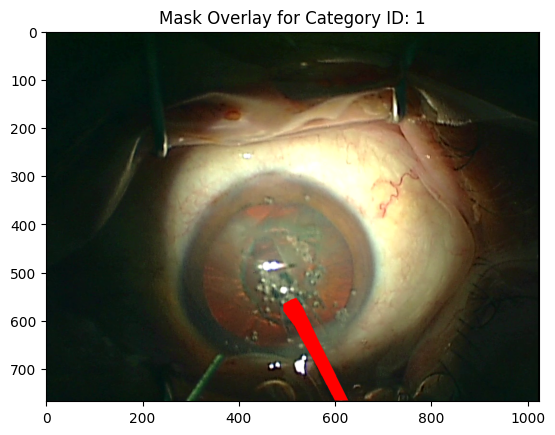

Category ID: 3
Category ID: 3 Category Name: Pupil


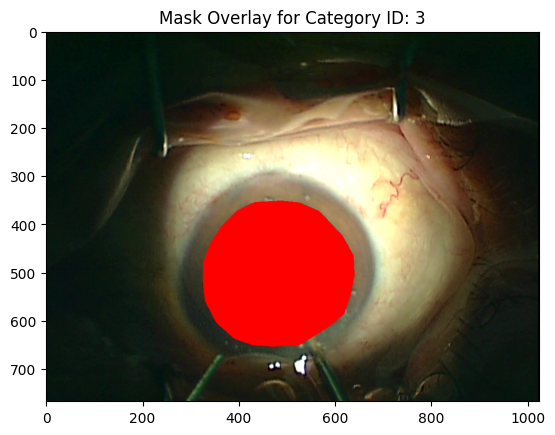

Category ID: 12
Category ID: 12 Category Name: Spatula


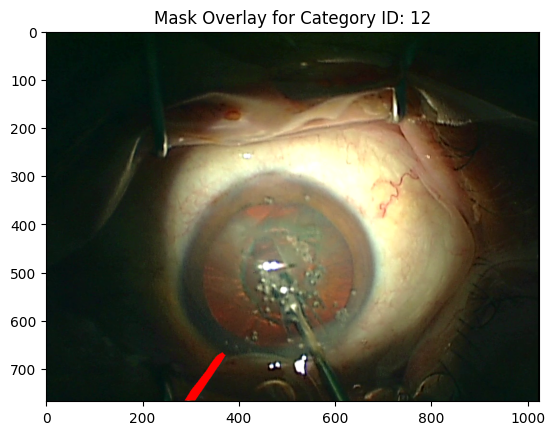

Category ID: 11
Category ID: 11 Category Name: Cornea


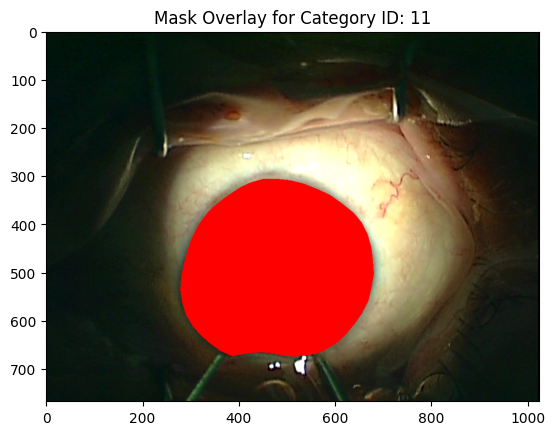

In [26]:
"""from pycocotools.coco import COCO

# Initialize COCO annotations instance
path_to_anns="../data/cataract-1k/Annotations/Coco-Annotations/case_5329/annotations/instances.json"
coco = COCO(path_to_anns)  # Replace annotation_file with the path to your COCO annotations file

# Get all annotation IDs for the category ID 11
ann_ids = coco.getAnnIds(catIds=[12])

# Load annotations for the category ID 11
annotations = coco.loadAnns(ann_ids)
images_info = coco.dataset['images']

# Function to get the file name from image ID
def get_file_name(image_id):
    for image_info in images_info:
        if image_info['id'] == image_id:
            return image_info['file_name']
    return None
# Print information about the instances with category ID 11
for ann in annotations:
    print("Image ID:", ann['image_id'])
    print("Category ID:", ann['category_id'])
    print("Bounding Box:", ann['bbox'])
    
    file_name = get_file_name(ann['image_id'])
    if file_name:
        print(f"File name for image ID {ann['image_id']}: {file_name}")
    else:
        print(f"No file name found for image ID {ann['image_id']}")
    break

    import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from PIL import Image

# Function to visualize image with segmentation masks
def visualize_image_with_masks(image_path, annotations, image_id):
    # Load COCO annotations
    coco = COCO(annotations)
    """coco.dataset=annotations
    coco.createIndex()"""
    # Load image
    image = Image.open(image_path)
    
    # Get annotation ids for the specified image id
    annotation_ids = coco.getAnnIds(imgIds=image_id)

    # Load annotations for the image
    annotations = coco.loadAnns(annotation_ids)
    
    category_names = [cat['name'] for cat in coco.loadCats([ann['category_id'] for ann in annotations])]
    print("Category Names:", category_names)
    # Create a mask array for the image
    mask_array = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)

    # Draw each segmentation mask on the mask array
    for ann in annotations:
        rle = coco_mask.frPyObjects(ann['segmentation'], image.size[1], image.size[0])
        mask = coco_mask.decode(rle)
        mask_array += mask.squeeze()
        print("Category ID:", ann['category_id'])
        
        # Overlay the mask on the image
        masked_image = np.array(image)
        masked_image[mask.squeeze() == 1] = [255, 0, 0]  # Set mask region to red
        category_info = coco.loadCats(ann['category_id'])[0]
        print("Category ID:", ann['category_id'], "Category Name:", category_info['name'])
        
        # Visualize the masked image
        plt.imshow(masked_image)
        plt.title("Mask Overlay for Category ID: " + str(ann['category_id']))
        plt.show()
       

# Example usage
image_path = '../data/cataract-1k/Annotations/Images-and-Supervisely-Annotations/case_5329/img/case5329_23.png'
annotations_file = 'path_to_your_annotations.json'
image_id = 1  # Change this to the desired image ID
visualize_image_with_masks(image_path, path_to_anns, ann['image_id'])

    # Add more information as needed
"""

In [38]:
np.random.seed(42)
array = np.arange(30)
np.random.shuffle(array)
train_len=int(30*0.8)
val_len=int(30*0.1)
train_idx=array[:train_len]
val_idx=array[train_len:train_len+val_len]
test_idx=array[train_len+val_len:]
print(train_idx,val_idx,test_idx)
train_files=[jsons_all[id] for id in train_idx]
val_files=[jsons_all[id] for id in val_idx]
test_files=[jsons_all[id] for id in test_idx]

path="../data/cataract-1k_updated"
old_path="../data/cataract-1k/Annotations/Images-and-Supervisely-Annotations"

if not os.path.exists(path):
    print("Create cataract1k updated directory")
    os.makedirs(path)
    os.makedirs(os.path.join(path,"train"))
    os.makedirs(os.path.join(path,"val"))
    os.makedirs(os.path.join(path,"test"))
    

for name,json_files in zip(["train","val","test"],[train_files,val_files,test_files]):
    
    # Initialize an empty dictionary to store the combined annotations
    combined_annotations = {
        "info": [],
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": categories
    }

    # Iterate over each JSON file
    for file in json_files:
        
        #coco = COCO(file)
        coco = COCO()
        coco.dataset = file
        coco.createIndex()

        # Update the combined annotations dictionary with annotations from the current file
        combined_annotations["images"].extend(coco.dataset["images"])
        combined_annotations["annotations"].extend(coco.dataset["annotations"])
        
    combined_annotations["info"]=coco.dataset["info"]
    combined_annotations["licenses"]=coco.dataset["licenses"]
    for i in range(len(combined_annotations["annotations"])):
        combined_annotations["annotations"][i]["id"]=i+1
    
    # Save the combined annotations to a new JSON file
    with open(os.path.join(path,name,name+'_cataract1k_annotations.json'), 'w') as f:
        json.dump(combined_annotations, f)


[27 15 23 17  8  9 28 24 12  0  4 16  5 13 11 22  1  2 25  3 21 26 18 29] [20  7 10] [14 19  6]
Create cataract1k updated directory
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating index...
index created!
creating i

In [24]:
# Old cataract-101 dataset
"""f=open("data/cataract-101/coco-annotations.json")
pre_json=json.load(f)
print(pre_json.keys())
categories=[]
for k,v in ZEISS_CATEGORIES.items():
    categories.append({"id":k,"name":v})

new_annotations=[]

for ann in pre_json["annotations"]:
    for k,v in ZEISS_TO_CATARACT1K.items():
        
        if ann["category_id"] in v:
            
            ann["category_id"]=k
            new_annotations.append(ann)
            break
        
final_json={"info":pre_json["info"],"images":pre_json["images"],
            "annotations":new_annotations,"categories": categories}

with open("cataract101-zeiss-mapped.json", "w") as json_file:
    json.dump(final_json, json_file)"""


dict_keys(['info', 'images', 'categories', 'annotations'])


In [27]:
# Initialize COCO instance with annotation file
coco = COCO("/notebooks/data/cataract-1k/Annotations/Coco-Annotations/case_5013/annotations/instances.json")
#path="data/cataract-101/2019-10-16_10-13-16_V.mp4_00397.jpg"
img, mask,path=cadis_train_dataset[15]
image = cv2.imread(path)
# Load annotations for the image
ann_ids = coco.getAnnIds(imgIds=16)

annotations = coco.loadAnns(ann_ids)

# Draw annotations on the image
for ann in annotations:
    bbox = ann['bbox']
    category_id = ann['category_id']
    print(category_id)
    category_info = coco.loadCats(category_id)[0]
    category_name = category_info['name']
    x, y, w, h = [int(coord) for coord in bbox]
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(image, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image with annotations
cv2.imshow('Image with Annotations', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

loading annotations into memory...
Done (t=10.68s)
creating index...
index created!
11
10
6


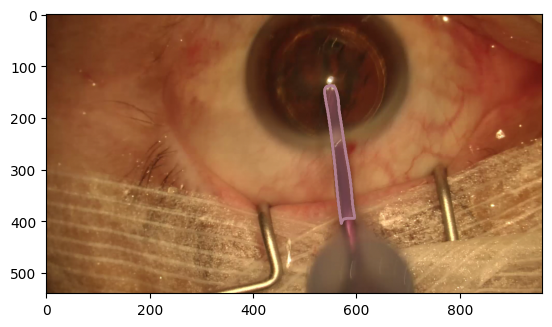

In [28]:

annIds = coco.getAnnIds(imgIds=16, catIds=[6], iscrowd=False)
anns = coco.loadAnns(annIds)
plt.imshow(Image.open(os.getcwd()+"/"+path))#(os.getcwd()+"/"+"data/cataract-101/2019-10-16_10-13-16_V.mp4_00397.jpg"))
coco.showAnns(anns)

In [5]:
for i in range(len(cadis_train_dataset)):
    img,mask,path=cadis_train_dataset[i]
    if "Video3_frame001870" in path:
        print(i)
        break

217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  6  10  11 255]


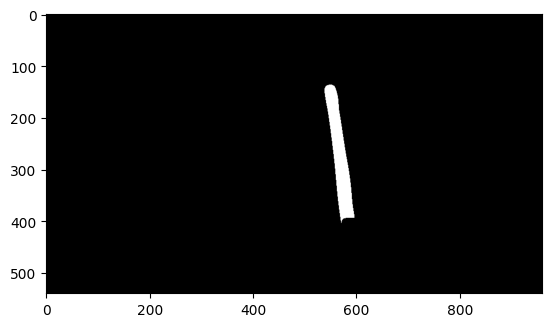

In [26]:
img_path="Video3_frame001870"
img, mask,path=cadis_train_dataset[15]
print(np.unique(mask.numpy()))
class_num=6
class_mask = mask.numpy() == class_num
overlay = np.zeros(img.permute(1, 2, 0).numpy().shape)
overlay[class_mask] = NEW_COLORS[class_num % len(COLORS)]
#overlay /= 255.0
plt.imshow(overlay)